https://arthurflor23.medium.com/handwritten-text-recognition-using-tensorflow-2-0-f4352b7afe16

http://www.jpuigcerver.net/pubs/jpuigcerver_icdar2017.pdf

http://www.tbluche.com/files/icdar17_gnn.pdf

https://github.com/mf1024/Batch-Renormalization-PyTorch/blob/master/batch_renormalization.py

https://dl.acm.org/doi/abs/10.1145/3395027.3419603

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U catalyst

     |████████████████████████████████| 491kB 14.1MB/s 
     |████████████████████████████████| 317kB 30.9MB/s 
     |████████████████████████████████| 163kB 30.2MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 


In [ ]:
!git clone --recursive https://github.com/parlance/ctcdecode.git
!cd ctcdecode && pip install .

Cloning into 'ctcdecode'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1063 (delta 6), reused 7 (delta 2), pack-reused 1047
Receiving objects: 100% (1063/1063), 763.61 KiB | 1.87 MiB/s, done.
Resolving deltas: 100% (509/509), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Cloning into '/content/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 90, done.        
remote: Counting objects: 100% (90/90), done.        
remote: Compressing objects: 100% (64/64), done.        
remote: Total 13672 (delta 41), reused 54 (delta 2

In [ ]:
!unzip '/content/drive/My Drive/AIJ/train.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/images/272_17_28.jpg  
  inflating: __MACOSX/train/images/._272_17_28.jpg  
  inflating: train/images/196_1_8.jpg  
  inflating: __MACOSX/train/images/._196_1_8.jpg  
  inflating: train/images/41_10_9.jpg  
  inflating: __MACOSX/train/images/._41_10_9.jpg  
  inflating: train/images/212_34_17.jpg  
  inflating: __MACOSX/train/images/._212_34_17.jpg  
  inflating: train/images/412_13_19.jpg  
  inflating: __MACOSX/train/images/._412_13_19.jpg  
  inflating: train/images/116_18_3.jpg  
  inflating: __MACOSX/train/images/._116_18_3.jpg  
  inflating: train/images/416_27_4.jpg  
  inflating: __MACOSX/train/images/._416_27_4.jpg  
  inflating: train/images/37_2_0.jpg  
  inflating: __MACOSX/train/images/._37_2_0.jpg  
  inflating: train/images/430_35_14.jpg  
  inflating: __MACOSX/train/images/._430_35_14.jpg  
  inflating: train/images/230_25_3.jpg  
  inflating: __MACOSX/train/images/._230_25_3.jpg  
  

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch

import torchvision.transforms as T
import torchvision.transforms.functional as VF
from torchvision import models

import editdistance

import numpy as np
import os
from tqdm.notebook import tqdm
from os.path import join
from collections import Counter
from itertools import islice
import re 
import io
import copy
import pickle

from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps

from catalyst.dl import Runner
from catalyst.callbacks import CheckpointCallback
from catalyst.callbacks.scheduler import SchedulerCallback
from catalyst.callbacks.early_stop import EarlyStoppingCallback
from catalyst.callbacks.tracing import TracerCallback
from catalyst.callbacks.metrics import auc, f1_score, accuracy
from catalyst.utils import set_global_seed, prepare_cudnn

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random
import math

random.seed(42)
torch.manual_seed(42)

from ctcdecode import CTCBeamDecoder
import multiprocessing

n_cpus = multiprocessing.cpu_count()

ModuleNotFoundError: ignored

In [ ]:
#В этой папке лежат txt файлы перевода
trans_dir = 'train/words'
#В этой папке лежат  jpg файлы изображений
image_dir = 'train/images'
print(len(os.listdir(trans_dir)))

6196


In [ ]:
def process_texts(image_dir,trans_dir):
    lens = []
    include_english = 0
    letters = ''

    lines = []
    names = []
    
    all_files = os.listdir(trans_dir)
    all_files.sort()
    for filename in sorted(os.listdir(image_dir)):
        if filename[:-3]+'txt' in all_files:
            name, _ = os.path.splitext(filename)
            txt_filepath = join(trans_dir, name + '.txt')
            with open(txt_filepath, 'r') as file:
                data = file.read()
                if len(data)==0:
                    continue

                lines.append(data)
                names.append(filename)
                lens.append(len(data))
                letters += data
    print('Максимальная длина строки:', max(Counter(lens).keys()))
    print('Количество строк с английскими буквами ',include_english)

    return names,lines,Counter(letters)

In [ ]:
names,lines,cnt = process_texts(image_dir,trans_dir)

Максимальная длина строки: 71
Количество строк с английскими буквами  0


In [ ]:
letters = set(cnt.keys())

letters = sorted(list(letters))
print(len(letters))
print('Символы train:', ''.join(letters))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

74
Символы train:  ()+/0123456789[]abdefghiklmnoprstu|×ǂабвгдежзийклмнопрстуфхцчшщъыьэюяѣ–⊕⊗


In [ ]:
tensor_lines = pad_sequence([torch.Tensor(text_to_labels(line)) for line in lines], batch_first=True, padding_value=-1.)

In [ ]:
def process_image(img):
    img = VF.resize(img, 128)
    img = VF.pad(img, (0, 0, max(1024 - img.size[0], 0), max(128 - img.size[1], 0)))
    img = VF.resize(img, (128, 1024))

    return VF.to_tensor(img)

# imgs = []

# for filename in tqdm(names):
#     img_name = join(image_dir, filename)
#     with Image.open(img_name) as img:
#         imgs.append(process_image(img))

# std, mean = torch.std_mean(torch.stack(imgs), dim=(0, 2, 3))
std, mean = (0.3847, 0.3815, 0.3763), (0.6519, 0.6352, 0.5940)

# nimages = len(names)
# mean = 0.
# std = 0.
# for filename in tqdm(names):
#     img_name = join(image_dir, filename)
#     with Image.open(img_name) as img:
#         tensor = process_image(img)
#     # Rearrange batch to be the shape of [B, C, W * H]
#     tensor = tensor.view(tensor.size(0), -1)
#     # Update total number of images
#     # nimages += batch.size(0)
#     # Compute mean and std here
#     mean += tensor.mean(1)
#     std += tensor.std(1)

# # Final step
# mean /= nimages
# std /= nimages

# print(mean)
# print(std)

In [ ]:
train_decoder = CTCBeamDecoder([*letters, '~'],
                               model_path=None,
                               blank_id=len(letters),
                               beam_width=1,
                               num_processes=n_cpus)

In [ ]:
max_width = 1024
max_height = 128

max_label_len = max(len(line) for line in lines)
print(max_label_len)

71


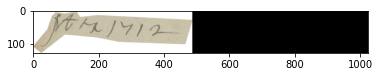

In [ ]:
from matplotlib.pyplot import imshow
resize1 = T.Resize(128)
resize2 = T.Resize((128, 1024))
with Image.open(image_dir + '/' + names[1]) as img:
    img = resize1(img)
    img = T.functional.pad(img, (0, 0, max(1024 - img.size[0], 0), max(128 - img.size[1], 0)))
    img = resize2(img)
    imshow(img)

In [ ]:
class DocDataset(Dataset):

    def __init__(self, filenames, lines, orig_lines, examples_num, max_width=max_width, max_height=max_height, train=True):
        super().__init__()
        
        self.examples_num = examples_num
        self.max_width = max_width
        self.max_height = max_height

        self.input_files = filenames
        self.output_lines = lines
        self.orig_lines = orig_lines

        self.resize1 = T.Resize(128)
        self.resize2 = T.Resize((128, 1024))

        # if train:
        #     self.pretensor = T.RandomApply(
        #         [T.Lambda(lambda x : x + torch.randn_like(x))], 
        #         p=0.5)
        # else:
        #     self.pretensor = nn.Identity()

        self.transform = T.Compose([
                                    T.ToTensor(),
                                    T.Normalize(mean, std),
                                    ])
        if train:
            self.posttensor = T.Compose([
                                         T.RandomApply([T.Lambda(lambda x : x + (0.25) * torch.randn_like(x))]),
                                        #  T.RandomErasing(scale=(0.02, 0.1)),
            ])
        else:
            self.posttensor = nn.Identity()
    
    def __len__(self):
        return self.examples_num

    def get_padding(self, img_size):
        return (0, 0, max(1024 - img_size[0], 0), max(128 - img_size[1], 0))
    
    def process_image(self, img):
        img = VF.resize(img, 128)
        img = VF.pad(img, (0, 0, max(1024 - img.size[0], 0), max(128 - img.size[1], 0)))
        img = VF.resize(img, (128, 1024))

        return img
    
    def __getitem__(self, i):
        img_name = join(image_dir, self.input_files[i])
        with Image.open(img_name) as img:
            x = self.process_image(img)
            # x = self.pretensor(x)
            x = self.transform(x)
            x = self.posttensor(x)
        return {'x': x, 'targets': self.output_lines[i],
                'target_lens': len(self.orig_lines[i]), 'orig_lines': self.orig_lines[i]}

In [ ]:
# CNN-BLSTM
class CNNBLSTM(nn.Module):
    def __init__(self, conv_drop=0.2, lstm_drop=0.5):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.lelu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        self.lelu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.dropout3 = nn.Dropout2d(conv_drop)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(48)
        self.lelu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.dropout4 = nn.Dropout2d(conv_drop)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.norm4 = nn.BatchNorm2d(64)
        self.lelu4 = nn.LeakyReLU()

        self.dropout5 = nn.Dropout2d(conv_drop)
        self.conv5 = nn.Conv2d(64, 80, kernel_size=3, padding=1)
        self.norm5 = nn.BatchNorm2d(80)
        self.lelu5 = nn.LeakyReLU()

        self.flatten1 = nn.Flatten(1, 2)

        self.dropout6 = nn.Dropout(lstm_drop)
        self.lstm6 = nn.LSTM(80*16, hidden_size=256, num_layers=3, dropout=lstm_drop, bidirectional=True, batch_first=True)

        self.dropout7 = nn.Dropout(lstm_drop)
        self.linear = nn.Linear(2*256, len(letters) + 1)
    
    def forward(self, x):
        x = self.pool1(self.lelu1(self.norm1(self.conv1(x))))
        x = self.pool2(self.lelu2(self.norm2(self.conv2(x))))
        x = self.pool3(self.lelu3(self.norm3(self.conv3(self.dropout3(x)))))
        x = self.lelu4(self.norm4(self.conv4(self.dropout4(x))))
        x = self.lelu5(self.norm5(self.conv5(self.dropout5(x))))

        x = self.flatten1(x)
        x = x.transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout7(x)
        x = self.linear(x)

        return x

def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_uniform_(m.weight)
    # nn.init.kaiming_uniform_(m.weight)

model = CNNBLSTM()
model.apply(init_weights)

CNNBLSTM(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lelu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lelu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lelu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout2d(p=0.2, inplace=False)
  (conv4): 

In [ ]:
class GatedCNNBLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(12, 8, kernel_size=(3, 3))
        self.tanh1 = nn.Tanh()

        self.pool1 = nn.MaxPool2d((3, 3))

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(2, 4))
        self.tanh2 = nn.Tanh()

        self.gconv1 = nn.Conv2d(16, 16, kernel_size=(3, 3), padding=1)
        self.sigm1 = nn.Sigmoid()

        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3))
        self.tanh3 = nn.Tanh()

        self.gconv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.sigm2 = nn.Sigmoid()

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(2, 4))
        self.tanh4 = nn.Tanh()

        self.gconv3 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.sigm3 = nn.Sigmoid()

        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.tanh5 = nn.Tanh()
        self.pool = nn.MaxPool2d((1, 10))

        self.flatten = nn.Flatten(2, 3)

        self.lstm1 = nn.LSTM(128, hidden_size=128, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(2*128, 128)
        self.tanh = nn.Tanh()

        self.lstm2 = nn.LSTM(128, hidden_size=128, bidirectional=True, batch_first=True)

        self.linear2 = nn.Linear(2*128, len(letters) + 1)

    def forward(self, x):
        x = x.view(-1, x.shape[1] * 4, x.shape[2] // 2, x.shape[3] // 2)
        x = self.pool1(self.tanh1(self.conv1(x)))

        x1 = self.tanh2(self.conv2(x))
        gated_x = self.sigm1(self.gconv1(x1))
        x = self.pool2(x1*gated_x)

        x1 = self.tanh3(self.conv3(x))
        gated_x = self.sigm2(self.gconv2(x1))
        x = x1*gated_x

        x1 = self.tanh4(self.conv4(x))
        gated_x = self.sigm3(self.gconv3(x1))
        x = x1*gated_x

        x = self.tanh5(self.conv5(x))
        x = self.pool(x)

        x = self.flatten(x).transpose(1, 2)

        x, _ = self.lstm1(x)
        x = self.tanh(self.linear1(x))
        x, _ = self.lstm2(x)
        x = self.linear2(x)

        return x

model = GatedCNNBLSTM()

In [ ]:
# https://github.com/mf1024/Batch-Renormalization-PyTorch/blob/master/batch_renormalization.py
# Batch Renormalization for convolutional neural nets (2D) implementation based
# on https://arxiv.org/abs/1702.03275

class BatchNormalization2D(nn.Module):

    def __init__(self, num_features,  eps=1e-05, momentum = 0.1):

        super().__init__()

        self.eps = eps
        self.momentum = torch.tensor( (momentum), requires_grad = False)

        self.gamma = nn.Parameter(torch.ones((1, num_features, 1, 1), requires_grad=True))
        self.beta = nn.Parameter(torch.zeros((1, num_features, 1, 1), requires_grad=True))

        self.running_avg_mean = torch.ones((1, num_features, 1, 1), requires_grad=False)
        self.running_avg_std = torch.zeros((1, num_features, 1, 1), requires_grad=False)

    def forward(self, x):

        device = self.gamma.device

        batch_ch_mean = torch.mean(x, dim=(0,2,3), keepdim=True).to(device)
        batch_ch_std = torch.clamp(torch.std(x, dim=(0,2,3), keepdim=True), self.eps, 1e10).to(device)

        self.running_avg_std = self.running_avg_std.to(device)
        self.running_avg_mean = self.running_avg_mean.to(device)
        self.momentum = self.momentum.to(device)

        if self.training:

            x = (x - batch_ch_mean) / batch_ch_std
            x = x * self.gamma + self.beta

        else:

            x = (x - self.running_avg_mean) / self.running_avg_std
            x = self.gamma * x + self.beta

        self.running_avg_mean = self.running_avg_mean + self.momentum * (batch_ch_mean.data.to(device) - self.running_avg_mean)
        self.running_avg_std = self.running_avg_std + self.momentum * (batch_ch_std.data.to(device) - self.running_avg_std)

        return x


class BatchRenormalization2D(nn.Module):

    def __init__(self, num_features,  eps=1e-05, momentum=0.01, r_d_max_inc_step = 0.0001):
        super().__init__()

        self.eps = eps
        self.momentum = torch.tensor( (momentum), requires_grad = False)

        self.gamma = nn.Parameter(torch.ones((1, num_features, 1, 1)), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros((1, num_features, 1, 1)), requires_grad=True)

        self.running_avg_mean = torch.ones((1, num_features, 1, 1), requires_grad=False)
        self.running_avg_std = torch.zeros((1, num_features, 1, 1), requires_grad=False) 

        self.max_r_max = 3.0
        self.max_d_max = 5.0

        self.r_max_inc_step = r_d_max_inc_step
        self.d_max_inc_step = r_d_max_inc_step

        self.r_max = torch.tensor( (1.0), requires_grad = False)
        self.d_max = torch.tensor( (0.0), requires_grad = False)

    def forward(self, x):

        device = self.gamma.device

        batch_ch_mean = torch.mean(x, dim=(0,2,3), keepdim=True).to(device)
        batch_ch_std = torch.clamp(torch.std(x, dim=(0,2,3), keepdim=True), self.eps, 1e10).to(device)

        self.running_avg_std = self.running_avg_std.to(device)
        self.running_avg_mean = self.running_avg_mean.to(device)
        self.momentum = self.momentum.to(device)

        self.r_max = self.r_max.to(device)
        self.d_max = self.d_max.to(device)


        if self.training:

            r = torch.clamp(batch_ch_std / self.running_avg_std, 1.0 / self.r_max, self.r_max).to(device).data.to(device)
            d = torch.clamp((batch_ch_mean - self.running_avg_mean) / self.running_avg_std, -self.d_max, self.d_max).to(device).data.to(device)

            x = ((x - batch_ch_mean) * r )/ batch_ch_std + d
            x = self.gamma * x + self.beta

            if self.r_max < self.max_r_max:
                self.r_max += self.r_max_inc_step * x.shape[0]

            if self.d_max < self.max_d_max:
                self.d_max += self.d_max_inc_step * x.shape[0]

        else:

            x = (x - self.running_avg_mean) / self.running_avg_std
            x = self.gamma * x + self.beta

        self.running_avg_mean = self.running_avg_mean + self.momentum * (batch_ch_mean.data.to(device) - self.running_avg_mean)
        self.running_avg_std = self.running_avg_std + self.momentum * (batch_ch_std.data.to(device) - self.running_avg_std)

        return x

In [ ]:
class FullGatedConv2d(nn.Conv2d):
    def __init__(self, in_channels, **kwargs):
        super().__init__(in_channels, in_channels * 2, **kwargs)

        self.channels = in_channels
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        x = super().forward(x)
        gated_x = self.sigm(x[:, self.channels:, :, :])
        return x[:, :self.channels, :, :] * gated_x

class HTRFlorConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.prelu = nn.PReLU()
        self.br = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.br(self.prelu(self.conv(x)))
        return x

class HTRFlor(nn.Module):
    def __init__(self, htr_dropout=0.2, gru_dropout=0.5):
        super().__init__()

        self.conv_block1 = HTRFlorConvBlock(3, 16, kernel_size=(3, 3))
        self.gconv1 = FullGatedConv2d(16, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))

        self.conv_block2 = HTRFlorConvBlock(16, 32, kernel_size=(3, 3))
        self.gconv2 = FullGatedConv2d(32, kernel_size=(3, 3), padding=1)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv_block3 = HTRFlorConvBlock(32, 40, kernel_size=(2, 4))
        self.gconv3 = FullGatedConv2d(40, kernel_size=(3, 3), padding=1)
        self.drop3 = nn.Dropout2d(htr_dropout)

        self.conv_block4 = HTRFlorConvBlock(40, 48, kernel_size=(3, 3))
        self.gconv4 = FullGatedConv2d(48, kernel_size=(3, 3), padding=1)
        self.drop4 = nn.Dropout2d(htr_dropout)

        self.conv_block5 = HTRFlorConvBlock(48, 56, kernel_size=(2, 4))
        self.gconv5 = FullGatedConv2d(56, kernel_size=(3, 3), padding=1)
        self.drop5 = nn.Dropout2d(htr_dropout)

        self.conv_block6 = HTRFlorConvBlock(56, 64, kernel_size=(3, 3))
        # self.pool = nn.MaxPool2d((1, 2))

        self.flatten = nn.Flatten(1, 2)

        self.drop7 = nn.Dropout(gru_dropout)
        self.lstm7 = nn.LSTM(64*24, 128, num_layers=3, dropout=gru_dropout, bidirectional=True, batch_first=True)
        # self.lstm7 = nn.LSTM(64*24, 128, bidirectional=True, batch_first=True)

        # self.linear7 = nn.Linear(2*128, 256)

        # self.drop8 = nn.Dropout(gru_dropout)
        # self.lstm8 = nn.LSTM(256, 128, bidirectional=True, batch_first=True)

        self.linear8 = nn.Linear(2*128, len(letters) + 1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.pool1(self.gconv1(x))

        x = self.conv_block2(x)
        x = self.pool2(self.gconv2(x))

        x = self.conv_block3(x)
        x = self.drop3(self.gconv3(x))

        x = self.conv_block4(x)
        x = self.drop4(self.gconv4(x))

        x = self.conv_block5(x)
        x = self.drop5(self.gconv5(x))

        x = self.flatten(self.conv_block6(x))

        x = x.transpose(1, 2)

        x, _ = self.lstm7(self.drop7(x))
        # x = self.linear7(x)

        # x, _ = self.lstm8(self.drop8(x))
        x = self.linear8(x)

        return x

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == FullGatedConv2d:
        nn.init.kaiming_uniform_(m.weight)
    # nn.init.kaiming_uniform_(m.weight)

model = HTRFlor()
model.apply(init_weights)

HTRFlor(
  (conv_block1): HTRFlorConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu): PReLU(num_parameters=1)
    (br): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gconv1): FullGatedConv2d(
    16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (sigm): Sigmoid()
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_block2): HTRFlorConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu): PReLU(num_parameters=1)
    (br): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gconv2): FullGatedConv2d(
    32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (sigm): Sigmoid()
  )
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_block3): HTRFlorConvBlock(
    (conv): Conv2d(32, 40, kernel_size=(2, 4), stride=(1, 1))
    (prelu): 

In [ ]:
class Net(nn.Module):
    def __init__(self, hid_dim=256, n_layers=2, lstm_dropout=0.2):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=(4, 2), stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=(4, 2), stride=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.ReLU())
        
        self.layer4 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),  nn.MaxPool2d(kernel_size=(4, 1), padding=(1,0)))
        
        self.layer5 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(), nn.BatchNorm2d(512))
        
        self.layer6 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(), nn.BatchNorm2d(512), nn.MaxPool2d(kernel_size=(4, 1), padding=(1,0)))

        self.layer7 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=2))

        self.dropout = nn.Dropout(lstm_dropout)
        self.lstm = nn.LSTM(512, self.hid_dim, num_layers=self.n_layers, dropout=lstm_dropout, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2 * self.hid_dim, len(letters) + 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)

        x = self.dropout(x.squeeze(2).transpose(1, 2))
        lstm_out, _ = self.lstm(x)
        logits = self.linear(lstm_out)
        return logits

model = Net()

In [ ]:
train_names, valid_names, train_lines, valid_lines, train_orig_lines, valid_orig_lines = train_test_split(names, tensor_lines, lines, test_size=0.1, random_state=42)

train_dataset = DocDataset(train_names, train_lines, train_orig_lines, len(train_lines))
valid_dataset = DocDataset(valid_names, valid_lines, valid_orig_lines, len(valid_lines), train=False)

In [ ]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader   
}

In [ ]:
seed = 404
set_global_seed(seed)
prepare_cudnn(True)

In [ ]:
epochs = 200
lr = 1e-3
criterion = nn.CTCLoss(blank=len(letters))
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,
                                                 patience=10, min_lr=0.00001)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, verbose=True)

In [ ]:
!nvidia-smi

Sat Nov 21 16:12:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def metrics(model, x, orig_lines):
    model.eval()

    with torch.no_grad():
        predictions = F.softmax(model(x), dim=-1).cpu()

    model.train()
    
    beam_results, _, _, out_lens = train_decoder.decode(predictions)

    numCharErr = 0
    numCharTotal = 0
    numStringOK = 0
    numStringTotal = 0

    word_eds, word_true_lens = [], []

    for i in range(len(beam_results)):
        # pred = ''.join(letters[int(p)] for p in out[i] if int(p) != -1)
        pred = "".join(letters[n] for n in beam_results[i][0][:out_lens[i][0]])
        true = orig_lines[i]
        
        numStringOK += 1 if true == pred else 0
        numStringTotal += 1
        dist = editdistance.eval(pred, true)
        numCharErr += dist
        numCharTotal += len(true)

        pred_words = pred.split()
        true_words = true.split()
        word_eds.append(editdistance.eval(pred_words, true_words))
        word_true_lens.append(len(true_words))

    charErrorRate = numCharErr / numCharTotal
    wordErrorRate = sum(word_eds) / sum(word_true_lens) 
    stringAccuracy = numStringOK / numStringTotal
    
    return charErrorRate, wordErrorRate, stringAccuracy

In [ ]:
class CustomRunner(Runner):

  def _handle_batch(self, batch):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `train()`.
    x, y, lens, lines = batch['x'], batch['targets'], batch['target_lens'], batch['orig_lines']

    y_pred = F.log_softmax(self.model(x), dim=-1) # Forward pass

    T = y_pred.shape[1]         # Input sequence length
    C = len(letters) + 1        # Number of classes (including blank)
    N = x.shape[0]              # Batch size
    S = max_label_len           # Target sequence length of longest target in batch (padding length)

    input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
    target_lengths = lens

    # Compute the loss value
    # (the criterion is stored in `self.state` also)
    loss = self.criterion(y_pred.transpose(0, 1), y, input_lengths, target_lengths)
    # Update metrics (includes the metric that tracks the loss)
    charErrorRate, wordErrorRate, stringAccuracy = metrics(self.model, x, lines)
    self.batch_metrics.update({"loss": loss, 
                               "char_error": charErrorRate, 
                               "word_error": wordErrorRate, 
                               "string_accuracy": stringAccuracy})

    if self.is_train_loader:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

In [ ]:
model.train()
model = model.cuda()

runner = CustomRunner()

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=dataloaders,
    callbacks=[
        EarlyStoppingCallback(
            patience=20,
            metric="loss",
            minimize=True,
        ),
        SchedulerCallback(reduced_metric="loss"),
    ],
    num_epochs=epochs,
    verbose=True,
    main_metric="char_error",
    load_best_on_end=True,
    initial_seed=42,
    logdir="/content/drive/My Drive/AIJ/logs"
)

1/200 * Epoch (train): 100% 348/348 [01:58<00:00,  2.94it/s, char_error=1.000, loss=3.692, string_accuracy=0.000e+00, word_error=1.000]
1/200 * Epoch (valid): 100% 39/39 [00:10<00:00,  3.86it/s, char_error=1.000, loss=3.432, string_accuracy=0.000e+00, word_error=1.000]
[2020-11-21 16:14:16,397] 
1/200 * Epoch 1 (_base): lr=0.0010 | momentum=0.000e+00
1/200 * Epoch 1 (train): char_error=0.9999 | loss=4.1428 | string_accuracy=0.000e+00 | word_error=1.0000
1/200 * Epoch 1 (valid): char_error=1.0000 | loss=3.5330 | string_accuracy=0.000e+00 | word_error=1.0000
2/200 * Epoch (train): 100% 348/348 [01:57<00:00,  2.96it/s, char_error=1.000, loss=3.386, string_accuracy=0.000e+00, word_error=1.000]
2/200 * Epoch (valid): 100% 39/39 [00:09<00:00,  3.94it/s, char_error=1.000, loss=3.248, string_accuracy=0.000e+00, word_error=1.000]
[2020-11-21 16:16:26,640] 
2/200 * Epoch 2 (_base): lr=0.0010 | momentum=0.000e+00
2/200 * Epoch 2 (train): char_error=1.0000 | loss=3.4243 | string_accuracy=0.000e+00

In [ ]:
# !mkdir checkpoint
model = model.cpu()
# checkpoint_path = 'checkpoint/model.pth'
checkpoint_path = f'/content/drive/My Drive/AIJ/{type(model).__name__}.pth'
torch.save(model.state_dict(), checkpoint_path)

In [ ]:
# checkpoint_path = 'htrflor.pth'
checkpoint_path = f'/content/drive/My Drive/AIJ/{type(model).__name__}.pth'
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [ ]:
# model.eval()
# model = model.cpu()
# with torch.no_grad():
#     val_images = torch.cat([valid_dataset[i]['x'].unsqueeze(0) for i in range(len(valid_dataset)//10)], dim=0)
#     logits = model(val_images)
#     predictions = F.softmax(logits, dim=-1)

# decoded = list(map(lambda x: beam_search(x.numpy(), ['~', *letters], beam_size=8)[0], predictions))

# numCharErr = 0
# numCharTotal = 0
# numStringOK = 0
# numStringTotal = 0

# word_eds, word_true_lens = [], []

# print('Ground truth -> Recognized')	
# for i in range(len(decoded)):
#     pred = decoded[i]
#     true = valid_orig_lines[i]
    
#     numStringOK += 1 if true == pred else 0
#     numStringTotal += 1
#     dist = editdistance.eval(pred, true)
#     numCharErr += dist
#     numCharTotal += len(true)
    
#     pred_words = pred.split()
#     true_words = true.split()
#     word_eds.append(editdistance.eval(pred_words, true_words))
#     word_true_lens.append(len(true_words))
    
#     print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

# charErrorRate = numCharErr / numCharTotal
# wordErrorRate = sum(word_eds) / sum(word_true_lens) 
# stringAccuracy = numStringOK / numStringTotal
# print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
#       (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

In [ ]:
model_path = '/content/drive/My Drive/AIJ/train3.binary'
model_path2 = '/content/drive/My Drive/AIJ/train_pages_fixed.binary'
decoder = CTCBeamDecoder([*letters, '~'],
                         model_path=None,
						 alpha=0.01,
						 blank_id=len(letters), 
			 			 beam_width=100,
			 			 num_processes=n_cpus)

lm_decoder = CTCBeamDecoder([*letters, '~'],
                         model_path=model_path,
                         alpha=1.5,
						 blank_id=len(letters), 
						 beam_width=100,
						 num_processes=n_cpus)

lm1_decoder = CTCBeamDecoder([*letters, '~'],
                         model_path=model_path,
                         alpha=1.5,
						 beta=2.,
						 blank_id=len(letters), 
						 beam_width=100,
						 num_processes=n_cpus)

lm2_decoder = CTCBeamDecoder([*letters, '~'],
                         model_path=model_path2,
                         alpha=1.5,
						 beta=2.,
						 blank_id=len(letters), 
						 beam_width=100,
						 num_processes=n_cpus)

In [ ]:
model.eval()
model = model.cpu()
with torch.no_grad():
    predictions = []
    for batch in tqdm(valid_dataloader):
        predictions.append(F.softmax(model(batch['x']), dim=-1))
    predictions = torch.cat(predictions, dim=0)

beam_results, _, _, out_lens = decoder.decode(predictions)

numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(beam_results)):
    pred = "".join(letters[n] for n in beam_results[i][0][:out_lens[i][0]])
    true = valid_orig_lines[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))


Ground truth -> Recognized
[ERR:1] "никакого препятствия дат сему" -> "никакого препятствая дат сему"
[ERR:1] "винцию с малым уроном людей своiх" -> "винцию смалым уроном людей своiх"
[ERR:3] "стетину i не доходя мил за десят" -> "стетину i не доходямил задеят"
[ERR:2] "такого великаго" -> "таков о великаго"
[ERR:2] "чаемо отзовут а вѣтер бу" -> "чаемо отзовѣт а вѣтербу"
[OK] "мите iз старых капитаноф кото" -> "мите iз старых капитаноф кото"
[OK] "ли iли нѣт тѣ городы i будет" -> "ли iли нѣт тѣ городы i будет"
[ERR:7] "протифъ вас конечно сим способом дер" -> "протифъ васконачно сим с посободѣ"
[ERR:1] "первому iли въторому числу сего мѣ" -> "первому iли въторомѣ числу сего мѣ"
[OK] "ежели iнова указа вскорѣ не получит" -> "ежели iнова указа вскорѣ не получит"
[ERR:1] "на баталию не газордоват" -> "набаталию не газордоват"
[ERR:1] "ли по своему разсмотрению" -> "ли посвоему разсмотрению"
[OK] "ли оныя карабли" -> "ли оныя карабли"
[ERR:1] "i въсѣс руских войскъ то оные" -> "i въсѣс ру

166_5_6.jpg
на баталию не газордоват
набаталию не газордоват


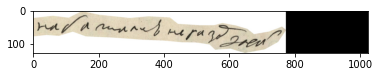

In [ ]:
from matplotlib.pyplot import imshow
resize1 = T.Resize(128)
resize2 = T.Resize((128, 1024))
number = 10
image_name = valid_names[number]
print(image_name)
print(valid_orig_lines[number])
model.eval()
with Image.open(image_dir + '/' + image_name) as img:
    img = resize1(img)
    img = T.functional.pad(img, (0, 0, max(1024 - img.size[0], 0), max(128 - img.size[1], 0)))
    img = resize2(img)
    imshow(img)

    img = VF.to_tensor(img)
    img = VF.normalize(img, mean, std)
    with torch.no_grad():
        output = F.softmax(model(img.unsqueeze(0)), dim=-1)

beam_results, _, _, out_lens = decoder.decode(output)

pred = "".join(letters[n] for n in beam_results[0][0][:out_lens[0][0]])
print(pred)

In [ ]:
model.eval()
model = model.cpu()
# with torch.no_grad():
#     predictions = []
#     for batch in tqdm(valid_dataloader):
#         predictions.append(F.softmax(model(batch['x']), dim=-1))
#     predictions = torch.cat(predictions, dim=0)

beam_results, _, _, out_lens = lm_decoder.decode(predictions)

numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(beam_results)):
    pred = "".join(letters[n] for n in beam_results[i][0][:out_lens[i][0]])
    true = valid_orig_lines[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[OK] "никакого препятствия дат сему" -> "никакого препятствия дат сему"
[OK] "винцию с малым уроном людей своiх" -> "винцию с малым уроном людей своiх"
[OK] "стетину i не доходя мил за десят" -> "стетину i не доходя мил за десят"
[ERR:2] "такого великаго" -> "такова великаго"
[OK] "чаемо отзовут а вѣтер бу" -> "чаемо отзовут а вѣтер бу"
[OK] "мите iз старых капитаноф кото" -> "мите iз старых капитаноф кото"
[OK] "ли iли нѣт тѣ городы i будет" -> "ли iли нѣт тѣ городы i будет"
[ERR:2] "протифъ вас конечно сим способом дер" -> "протифъ вас конечно сим способом дѣ"
[OK] "первому iли въторому числу сего мѣ" -> "первому iли въторому числу сего мѣ"
[OK] "ежели iнова указа вскорѣ не получит" -> "ежели iнова указа вскорѣ не получит"
[OK] "на баталию не газордоват" -> "на баталию не газордоват"
[OK] "ли по своему разсмотрению" -> "ли по своему разсмотрению"
[OK] "ли оныя карабли" -> "ли оныя карабли"
[OK] "i въсѣс руских войскъ то оные" -> "i въсѣс руских войскъ то он

In [ ]:
model.eval()
model = model.cpu()
# with torch.no_grad():
#     predictions = []
#     for batch in tqdm(valid_dataloader):
#         predictions.append(F.softmax(model(batch['x']), dim=-1))
#     predictions = torch.cat(predictions, dim=0)

beam_results, _, _, out_lens = lm1_decoder.decode(predictions)

numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(beam_results)):
    pred = "".join(letters[n] for n in beam_results[i][0][:out_lens[i][0]])
    true = valid_orig_lines[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[OK] "никакого препятствия дат сему" -> "никакого препятствия дат сему"
[OK] "винцию с малым уроном людей своiх" -> "винцию с малым уроном людей своiх"
[OK] "стетину i не доходя мил за десят" -> "стетину i не доходя мил за десят"
[ERR:2] "такого великаго" -> "такова великаго"
[OK] "чаемо отзовут а вѣтер бу" -> "чаемо отзовут а вѣтер бу"
[OK] "мите iз старых капитаноф кото" -> "мите iз старых капитаноф кото"
[OK] "ли iли нѣт тѣ городы i будет" -> "ли iли нѣт тѣ городы i будет"
[ERR:2] "протифъ вас конечно сим способом дер" -> "протифъ вас конечно сим способом дѣ"
[OK] "первому iли въторому числу сего мѣ" -> "первому iли въторому числу сего мѣ"
[OK] "ежели iнова указа вскорѣ не получит" -> "ежели iнова указа вскорѣ не получит"
[OK] "на баталию не газордоват" -> "на баталию не газордоват"
[OK] "ли по своему разсмотрению" -> "ли по своему разсмотрению"
[OK] "ли оныя карабли" -> "ли оныя карабли"
[OK] "i въсѣс руских войскъ то оные" -> "i въсѣс руских войскъ то он

In [ ]:
model.eval()
model = model.cpu()
# with torch.no_grad():
#     predictions = []
#     for batch in tqdm(valid_dataloader):
#         predictions.append(F.softmax(model(batch['x']), dim=-1))
#     predictions = torch.cat(predictions, dim=0)

beam_results, _, _, out_lens = lm2_decoder.decode(predictions)

numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(beam_results)):
    pred = "".join(letters[n] for n in beam_results[i][0][:out_lens[i][0]])
    true = valid_orig_lines[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[OK] "никакого препятствия дат сему" -> "никакого препятствия дат сему"
[OK] "винцию с малым уроном людей своiх" -> "винцию с малым уроном людей своiх"
[OK] "стетину i не доходя мил за десят" -> "стетину i не доходя мил за десят"
[ERR:2] "такого великаго" -> "такова великаго"
[OK] "чаемо отзовут а вѣтер бу" -> "чаемо отзовут а вѣтер бу"
[OK] "мите iз старых капитаноф кото" -> "мите iз старых капитаноф кото"
[OK] "ли iли нѣт тѣ городы i будет" -> "ли iли нѣт тѣ городы i будет"
[ERR:2] "протифъ вас конечно сим способом дер" -> "протифъ вас конечно сим способом дѣ"
[OK] "первому iли въторому числу сего мѣ" -> "первому iли въторому числу сего мѣ"
[OK] "ежели iнова указа вскорѣ не получит" -> "ежели iнова указа вскорѣ не получит"
[OK] "на баталию не газордоват" -> "на баталию не газордоват"
[OK] "ли по своему разсмотрению" -> "ли по своему разсмотрению"
[OK] "ли оныя карабли" -> "ли оныя карабли"
[OK] "i въсѣс руских войскъ то оные" -> "i въсѣс руских войскъ то он